In [265]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import pickle
from scipy import io
import networkx as nx

In [266]:
import numpy as np

# Specify the file path
file_path = '/Users/asalrangraziasl/Documents/ Projects_Master/ Inference/FCth.txt'

# Load the data into a NumPy array
data = np.loadtxt(file_path)

# Now, 'data' contains your dataset as a NumPy array

In [267]:
data

array([[1.        , 0.29007275, 0.33406276, ..., 0.27619268, 0.38820639,
        0.24870905],
       [0.29007275, 1.        , 0.6728313 , ..., 0.20622525, 0.31493987,
        0.20340271],
       [0.33406276, 0.6728313 , 1.        , ..., 0.18990944, 0.34645661,
        0.17841752],
       ...,
       [0.27619268, 0.20622525, 0.18990944, ..., 1.        , 0.4226791 ,
        0.48421177],
       [0.38820639, 0.31493987, 0.34645661, ..., 0.4226791 , 1.        ,
        0.45591268],
       [0.24870905, 0.20340271, 0.17841752, ..., 0.48421177, 0.45591268,
        1.        ]])

Average connectivity strength: 0.30562303109507366
Maximum connectivity strength: 1.0
Minimum connectivity strength: -0.0011110186433460477


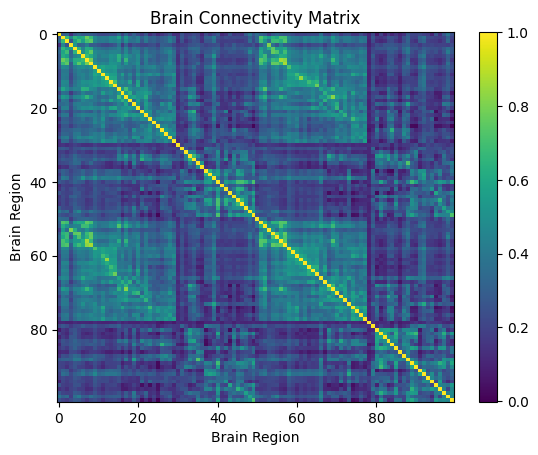

In [268]:
# Example: Calculate the average connectivity strength
average_strength = np.mean(data)
print("Average connectivity strength:", average_strength)

# Example: Calculate the maximum and minimum connectivity strengths
max_strength = np.max(data)
min_strength = np.min(data)
print("Maximum connectivity strength:", max_strength)
print("Minimum connectivity strength:", min_strength)

# Example: Visualize the connectivity matrix (optional)
import matplotlib.pyplot as plt

plt.imshow(data, cmap='viridis', origin='upper', aspect='auto')
plt.colorbar()
plt.title("Brain Connectivity Matrix")
plt.xlabel("Brain Region")
plt.ylabel("Brain Region")
plt.show()

In [269]:
# Set a threshold value (adjust as needed)
threshold = 0.5

# Create a binary connectivity matrix by applying the threshold
A_T = (data > threshold).astype('float64')
A_T

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [270]:
type(A_T)
print(A_T.shape)
print(A_T.dtype)

(100, 100)
float64


In [271]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [272]:
def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    first_loop_cond = True
    for part in all_part:

        if first_loop_cond:
            gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
            pair_list=[]
            for x in gooz_list:
                if x not in pair_list: pair_list.append(x)

            # H(p) formula
            H_P = 0
            for pair in pair_list:
                alpha, beta = pair
                l = l_ij(alpha, beta, A_T, part)
                r = r_ij(alpha, beta, part)
                h_p = math.log(r+1) + math.log(ncr(r, l))
                H_P += h_p

            Z += np.exp(-H_P)
            first_loop_cond = False
        # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)


        # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        parantez = ((l + 1)/(r+2))

        # print(Z)
        big_sum += parantez* np.exp(-H_P)
        R_ij = big_sum/Z
        # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))





In [273]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P,AT_tmp):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<=j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, AT_tmp, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

In [274]:
def Metropolis(T,ens,AT_tmp):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(100)].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions,AT_tmp) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions,AT_tmp)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
        ppp = [ele for ele in partitions if ele != []]
        e.append(ppp)
        #     partitions = [ele for ele in partitions if ele != []]
        #
        # ppp=copy.deepcopy(partitions)
        # e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions,AT_tmp))
        print(kk)
    return(e)

In [275]:
es = Metropolis(10000, 20,A_T)

  5%|▌         | 1/20 [00:33<10:43, 33.87s/it]

1821.4689107409245
9999


 10%|█         | 2/20 [01:06<10:01, 33.41s/it]

1898.7443362788642
9999


 15%|█▌        | 3/20 [01:40<09:30, 33.58s/it]

1892.7289576795504
9999


 20%|██        | 4/20 [02:15<09:02, 33.92s/it]

1888.5736919949882
9999


 25%|██▌       | 5/20 [02:48<08:27, 33.83s/it]

1886.2887661323396
9999


 30%|███       | 6/20 [03:20<07:42, 33.03s/it]

1898.938193563623
9999


 35%|███▌      | 7/20 [03:53<07:11, 33.18s/it]

1904.2636234826405
9999


 40%|████      | 8/20 [04:27<06:40, 33.41s/it]

1846.0562277332428
9999


 45%|████▌     | 9/20 [04:58<05:57, 32.49s/it]

1890.317208259995
9999


 50%|█████     | 10/20 [05:31<05:25, 32.60s/it]

1895.7929269079225
9999


 55%|█████▌    | 11/20 [06:02<04:49, 32.18s/it]

1884.748515929684
9999


 60%|██████    | 12/20 [06:34<04:18, 32.30s/it]

1860.1146921631175
9999


 65%|██████▌   | 13/20 [07:05<03:42, 31.76s/it]

1863.7496226240933
9999


 70%|███████   | 14/20 [07:36<03:09, 31.52s/it]

1904.9432305167238
9999


 75%|███████▌  | 15/20 [08:10<02:40, 32.19s/it]

1863.1211639082703
9999


 80%|████████  | 16/20 [08:43<02:10, 32.64s/it]

1890.7595013711298
9999


 85%|████████▌ | 17/20 [09:17<01:39, 33.04s/it]

1918.5750397119723
9999


 90%|█████████ | 18/20 [09:48<01:04, 32.34s/it]

1801.5836214120973
9999


 95%|█████████▌| 19/20 [10:18<00:31, 31.80s/it]

1837.498077114122
9999


100%|██████████| 20/20 [10:50<00:00, 32.52s/it]

1876.966234307309
9999


In [276]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs from
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

In [277]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

  0%|          | 0/9122 [00:00<?, ?it/s]/var/folders/jw/91h5jhw96l52xy2j8gdkkz7r0000gn/T/ipykernel_2379/779491313.py:36: RuntimeWarning: invalid value encountered in scalar divide
  R_ij = big_sum/Z
100%|██████████| 9122/9122 [00:28<00:00, 321.05it/s]


In [278]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    selected_links = link_remover(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 0
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(zero_fake),2))
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

/var/folders/jw/91h5jhw96l52xy2j8gdkkz7r0000gn/T/ipykernel_2379/779491313.py:36: RuntimeWarning: invalid value encountered in scalar divide
  R_ij = big_sum/Z


the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan


Text(0.5, 1.0, 'Missing intractions')

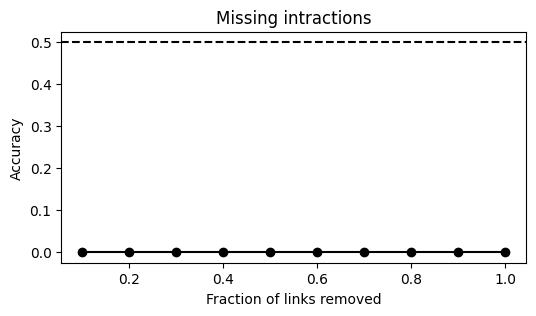

In [279]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')
